Linear Regression → RMSE: 9404.41, R2: 0.83


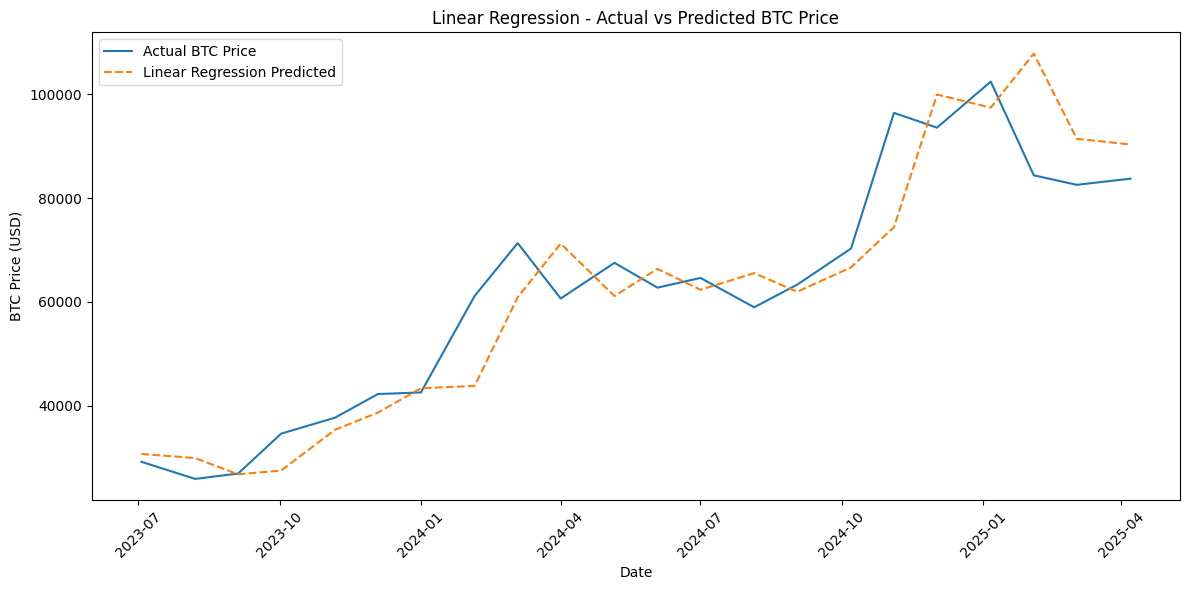

Random Forest → RMSE: 22988.51, R2: -0.05


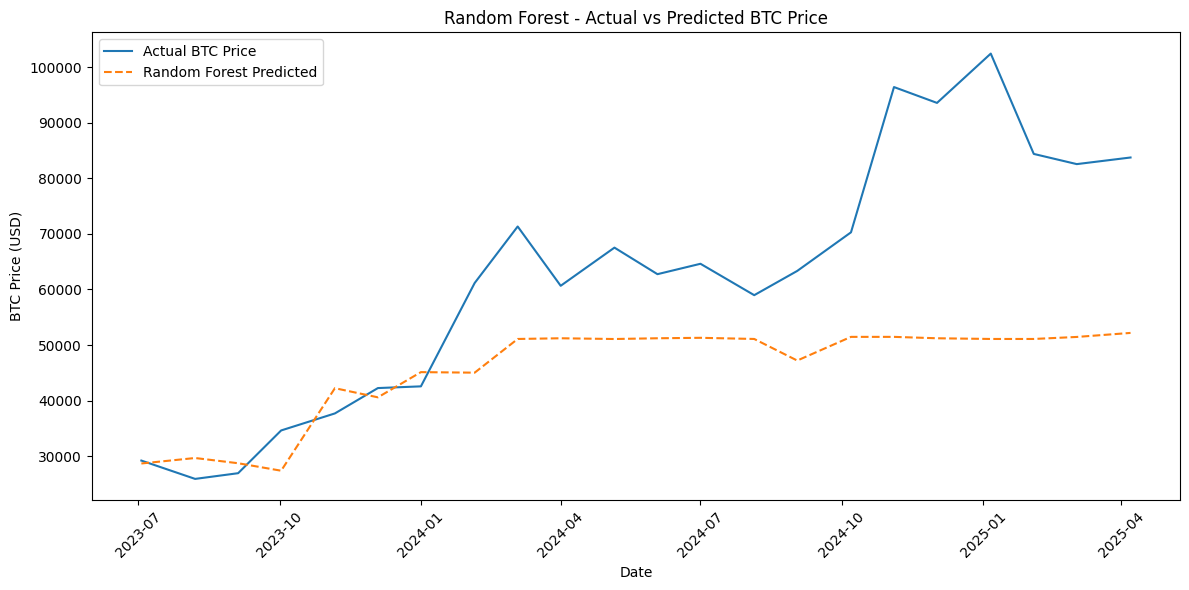

SVR → RMSE: 57029.57, R2: -5.43


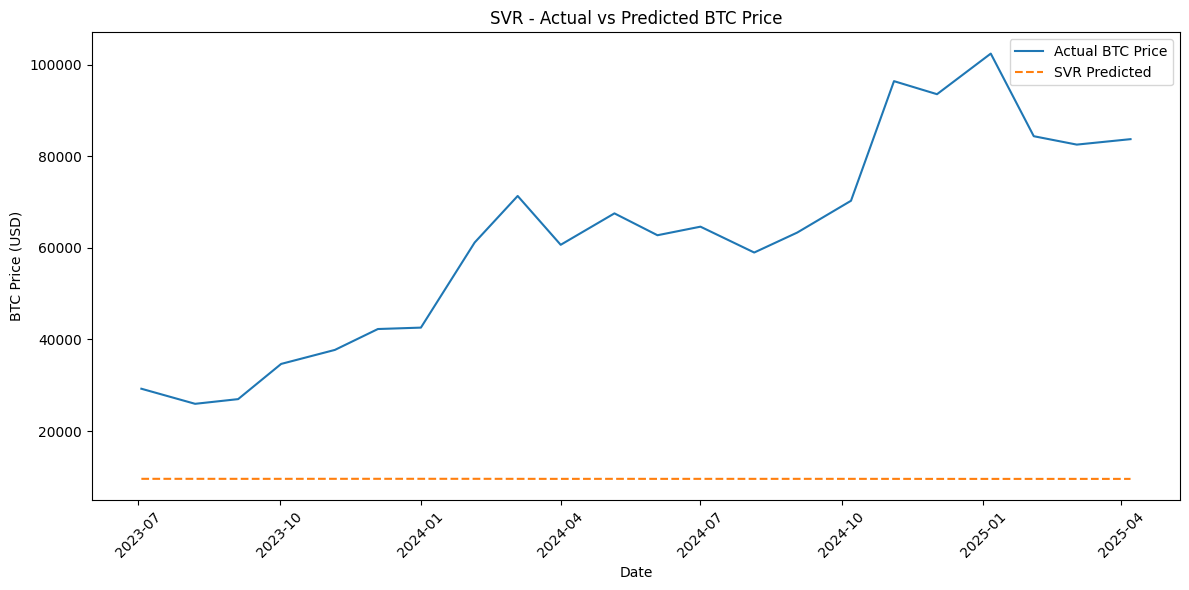

In [5]:
# =========================
# Step 1: Import Libraries
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# =========================
# Step 2: Load Datasets
# =========================
btc = pd.read_csv("C:/Users/manda/Downloads/Bitcoin Historical Data (1).csv")
eth = pd.read_csv("C:/Users/manda/Downloads/Ethereum Historical Data.csv")
dow = pd.read_csv("C:/Users/manda/Downloads/Dow Jones Industrial Average Historical Data.csv")

# =========================
# Step 3: Clean and Sort
# =========================
for df in [btc, eth, dow]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

# =========================
# Step 4: Resample to Weekly
# =========================
btc_weekly = btc.resample('W-MON', on='Date').last().reset_index()
eth_weekly = eth.resample('W-MON', on='Date').last().reset_index()
dow_weekly = dow.resample('W-MON', on='Date').last().reset_index()

btc_weekly.rename(columns={'Price': 'BTC_Price'}, inplace=True)
eth_weekly.rename(columns={'Price': 'ETH_Price'}, inplace=True)
dow_weekly.rename(columns={'Price': 'DOW_Price'}, inplace=True)

# =========================
# Step 5: Merge Datasets
# =========================
df = btc_weekly[['Date', 'BTC_Price']].merge(
    eth_weekly[['Date', 'ETH_Price']], on='Date', how='inner'
).merge(
    dow_weekly[['Date', 'DOW_Price']], on='Date', how='inner'
)

# =========================
# Step 6: Clean Price Columns
# =========================
for col in ['BTC_Price', 'ETH_Price', 'DOW_Price']:
    df[col] = df[col].str.replace(',', '').astype(float)

df.dropna(inplace=True)

# =========================
# Step 7: Feature Engineering
# =========================
df['BTC_Price_Lag1'] = df['BTC_Price'].shift(1)
df['ETH_Price_Lag1'] = df['ETH_Price'].shift(1)
df['DOW_Price_Lag1'] = df['DOW_Price'].shift(1)

df.dropna(inplace=True)

X = df[['BTC_Price_Lag1', 'ETH_Price_Lag1', 'DOW_Price_Lag1']]
y = df['BTC_Price']

# =========================
# Step 8: Train-Test Split
# =========================
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = df['Date'].iloc[split_idx:]

# =========================
# Step 9: Model Training & Evaluation
# =========================
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))  # ✅ FIXED HERE
    r2 = r2_score(y_test, y_pred)

    print(f"{name} → RMSE: {rmse:.2f}, R2: {r2:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(dates_test, y_test, label='Actual BTC Price')
    plt.plot(dates_test, y_pred, label=f'{name} Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('BTC Price (USD)')
    plt.title(f'{name} - Actual vs Predicted BTC Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# =========================
# Step 10: Run All Models
# =========================
evaluate_model(LinearRegression(), "Linear Regression")
evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest")
evaluate_model(SVR(kernel='rbf'), "SVR")
